In [25]:
import os
import warnings
import pprint
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

from matplotlib import gridspec
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, StackingClassifier
from xgboost import XGBClassifier


from sklearn import tree

from os import system
from IPython.display import Image


warnings.filterwarnings('ignore')                                       # Ignore/Do not display warnings

main_data = pd.read_csv('Cars-dataset.csv')

In [2]:
main_data.head(10)

,Age,Gender,Engineer,MBA,Work Exp,Salary,Distance,license,Opt_service
0,28,Male,1,0,5,14.4,5.1,0,0
1,24,Male,1,0,6,10.6,6.1,0,0
2,27,Female,1,0,9,15.5,6.1,0,0
3,25,Male,0,0,1,7.6,6.3,0,0
4,25,Female,0,0,3,9.6,6.7,0,0
5,21,Male,0,0,3,9.5,7.1,0,0
6,23,Male,1,1,3,11.7,7.2,0,0
7,23,Male,0,0,0,6.5,7.3,0,0
8,24,Male,1,0,4,8.5,7.5,0,0
9,28,Male,1,0,6,13.7,7.5,1,0


In [3]:
main_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          418 non-null    int64  
 1   Gender       418 non-null    object 
 2   Engineer     418 non-null    int64  
 3   MBA          418 non-null    int64  
 4   Work Exp     418 non-null    int64  
 5   Salary       418 non-null    float64
 6   Distance     418 non-null    float64
 7   license      418 non-null    int64  
 8   Opt_service  418 non-null    int64  
dtypes: float64(2), int64(6), object(1)
memory usage: 29.5+ KB


In [4]:
oneHotCols = ["Gender"]
main_data = pd.get_dummies(main_data, columns=oneHotCols)
main_data.head(10)

,Age,Engineer,MBA,Work Exp,Salary,Distance,license,Opt_service,Gender_Female,Gender_Male
0,28,1,0,5,14.4,5.1,0,0,0,1
1,24,1,0,6,10.6,6.1,0,0,0,1
2,27,1,0,9,15.5,6.1,0,0,1,0
3,25,0,0,1,7.6,6.3,0,0,0,1
4,25,0,0,3,9.6,6.7,0,0,1,0
5,21,0,0,3,9.5,7.1,0,0,0,1
6,23,1,1,3,11.7,7.2,0,0,0,1
7,23,0,0,0,6.5,7.3,0,0,0,1
8,24,1,0,4,8.5,7.5,0,0,0,1
9,28,1,0,6,13.7,7.5,1,0,0,1


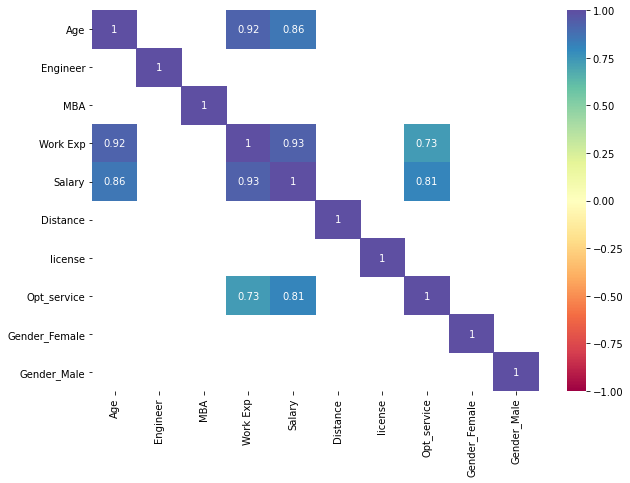

In [5]:
# variables that have more than 0.7 correlation
df = main_data.copy()
plt.figure(figsize=(10,7))
sns.heatmap(df.corr()[df.corr()>0.7],annot = True,vmax = 1, vmin = -1, cmap='Spectral');

In [6]:
# Functions to calculate different metrics

def DisplayConfusionMatrix(model, y_actual, labels=[1,0]):
    y_predict = model.predict(x_test)
    confusion_matrix = metrics.confusion_matrix(y_actual, y_predict, labels=[0, 1])
    confusion_matix_df = pd.DataFrame(
        confusion_matrix,
        index   = [i for i in ["Actual No", "Actual Yes"]],
        columns = [i for i in ["Predicted - No", "Predicted - Yes"]])
    
    group_counts = ["{0:0.0f}".format(value) for value in confusion_matrix.flatten()]
    group_percetages = ["{0:.2%}".format(value) for value in confusion_matrix.flatten()/np.sum(confusion_matrix)]
    
    labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts, group_percetages)]
    labels = np.array(labels).reshape(2, 2)
    plt.figure(figsize= (10,7))
    sns.heatmap(confusion_matix_df, annot=labels,fmt='')
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    
def GetMetricsScore(model):
    
    pred_train = model.predict(x_train)
    pred_test  = model.predict(x_test)
    
    train_accuracy = model.score(x_train, y_train)
    test_accuracy  = model.score(x_test, y_test)
    
    train_recall = metrics.recall_score(y_train, pred_train)
    test_recall  = metrics.recall_score(y_test, pred_test)
    
    train_precision = metrics.precision_score(y_train, pred_train)
    test_precision  = metrics.precision_score(y_test, pred_test)

    f1_score_train = 2 * ((train_precision * train_recall)/(train_precision + train_recall))
    f1_score_test = 2 * ((test_precision * test_recall)/(test_precision + test_recall))
    
    return {
        'Accuracy_Test'   : test_accuracy,
        'Accuracy_Train'  : train_accuracy,
        'Recall_Test'     : test_recall,
        'Recall_Train'    : train_recall,
        'Precision_Test'  : test_precision,
        'Precision_Train' : train_precision,
        'F1_Score_Train'  : f1_score_train,
        'F1_Score_Test'   : f1_score_test
    }
        

def DisplayImportance(model):
    gini_importances = pd.DataFrame(model.feature_importances_, columns=["Imp"], index=x_train.columns).sort_values(by = "Imp")
    print(gini_importances)
    
def DisplayImportanceChart(model):
    importances = model.feature_importances_
    indices = np.argsort(importances)

    plt.figure(figsize=(12, 12))
    plt.title('Feature Importance')
    plt.barh(range(len(indices)), importances[indices], color='violet', align='center')
    plt.yticks(range(len(indices)), [list(X.columns)[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()
    
def PlotTree(model, size = [20, 30]):
    plt.figure(figsize=(size[0],size[1]))
    tree.plot_tree(model, feature_names=feature_names, filled=True, fontsize=9, node_ids=True, class_names=True)
    plt.show()
    
def PrintCoeficients(model):
    coefs = pd.DataFrame(
        np.append(model.coef_, model.intercept_),
        index=x_train.columns.tolist() + ["Intercept"],
        columns=["Coefficients"],
    )

    coefs.sort_values('Coefficients')

In [7]:
X = main_data.drop("Opt_service", axis=1)
Y = main_data.pop("Opt_service")
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=1)

In [8]:
print(x_train.shape, x_test.shape)

(292, 9) (126, 9)


In [9]:
print(y_test.value_counts(1))

0    0.912698
1    0.087302
Name: Opt_service, dtype: float64


In [10]:
rf = RandomForestClassifier(random_state=1)
rf.fit(x_train, y_train)

RandomForestClassifier(random_state=1)

In [11]:
rf_score = GetMetricsScore(rf)
pprint.pprint(rf_score)

{'Accuracy_Test': 1.0,
 'Accuracy_Train': 1.0,
 'F1_Score_Test': 1.0,
 'F1_Score_Train': 1.0,
 'Precision_Test': 1.0,
 'Precision_Train': 1.0,
 'Recall_Test': 1.0,
 'Recall_Train': 1.0}


In [12]:
# bagging classifier with base estimator  =Logistic Regression
bag_lr = BaggingClassifier(random_state=1, base_estimator = LogisticRegression(random_state = 1))
bag_lr.fit(x_train, y_train)

BaggingClassifier(base_estimator=LogisticRegression(random_state=1),
                  random_state=1)

In [13]:
bag_lr_score = GetMetricsScore(bag_lr)
pprint.pprint(bag_lr_score)

{'Accuracy_Test': 0.9841269841269841,
 'Accuracy_Train': 0.9897260273972602,
 'F1_Score_Test': 0.9166666666666666,
 'F1_Score_Train': 0.9361702127659574,
 'Precision_Test': 0.8461538461538461,
 'Precision_Train': 0.9565217391304348,
 'Recall_Test': 1.0,
 'Recall_Train': 0.9166666666666666}


In [35]:
print("Bagging")
bag_lr = BaggingClassifier(random_state=1, base_estimator = LogisticRegression(random_state = 1))
bag_lr.fit(x_train, y_train)
bag_lr_score = GetMetricsScore(bag_lr)
pprint.pprint(bag_lr_score)

print("Forest")
forest = RandomForestClassifier()
forest.fit(x_train, y_train)
forest_score = GetMetricsScore(forest)
pprint.pprint(forest_score)

Bagging
{'Accuracy_Test': 0.9841269841269841,
 'Accuracy_Train': 0.9897260273972602,
 'F1_Score_Test': 0.9166666666666666,
 'F1_Score_Train': 0.9361702127659574,
 'Precision_Test': 0.8461538461538461,
 'Precision_Train': 0.9565217391304348,
 'Recall_Test': 1.0,
 'Recall_Train': 0.9166666666666666}
Forest
{'Accuracy_Test': 1.0,
 'Accuracy_Train': 1.0,
 'F1_Score_Test': 1.0,
 'F1_Score_Train': 1.0,
 'Precision_Test': 1.0,
 'Precision_Train': 1.0,
 'Recall_Test': 1.0,
 'Recall_Train': 1.0}


In [40]:
scores = []
for i in range(1,6):
    bag = BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=1,max_depth = i),random_state=1)
    bag.fit(x_train, y_train)
    bag_lr_score = GetMetricsScore(bag)
    print(i)
    pprint.pprint(f"F1 Train : {bag_lr_score['F1_Score_Train']}")

1
'F1 Train : 0.8400000000000001'
2
'F1 Train : 0.9787234042553191'
3
'F1 Train : 0.9787234042553191'
4
'F1 Train : 0.9787234042553191'
5
'F1 Train : 1.0'


In [41]:
# Adaboost classifier
X_train = x_train
abc = AdaBoostClassifier(random_state=1)
abc.fit(X_train, y_train)

# GradientBoost classifier
gbm = GradientBoostingClassifier(random_state=1)
gbm.fit(X_train, y_train)

#XGBoost classifier
xgb = XGBClassifier(random_state=1, eval_metric = 'logloss')
xgb.fit(X_train, y_train)

# predicting on training set
abc_predict = abc.predict(X_train)
gbm_predict = gbm.predict(X_train)
xgb_predict = xgb.predict(X_train)

# Checking model performance
print('ABC')
score = GetMetricsScore(abc)
pprint.pprint(score)

print('GBM')
score = GetMetricsScore(gbm)
pprint.pprint(score)

print('XGB')
score = GetMetricsScore(xgb)
pprint.pprint(score)

ABC
{'Accuracy_Test': 1.0,
 'Accuracy_Train': 1.0,
 'F1_Score_Test': 1.0,
 'F1_Score_Train': 1.0,
 'Precision_Test': 1.0,
 'Precision_Train': 1.0,
 'Recall_Test': 1.0,
 'Recall_Train': 1.0}
GBM
{'Accuracy_Test': 0.9920634920634921,
 'Accuracy_Train': 1.0,
 'F1_Score_Test': 0.9565217391304348,
 'F1_Score_Train': 1.0,
 'Precision_Test': 0.9166666666666666,
 'Precision_Train': 1.0,
 'Recall_Test': 1.0,
 'Recall_Train': 1.0}
XGB
{'Accuracy_Test': 1.0,
 'Accuracy_Train': 1.0,
 'F1_Score_Test': 1.0,
 'F1_Score_Train': 1.0,
 'Precision_Test': 1.0,
 'Precision_Train': 1.0,
 'Recall_Test': 1.0,
 'Recall_Train': 1.0}


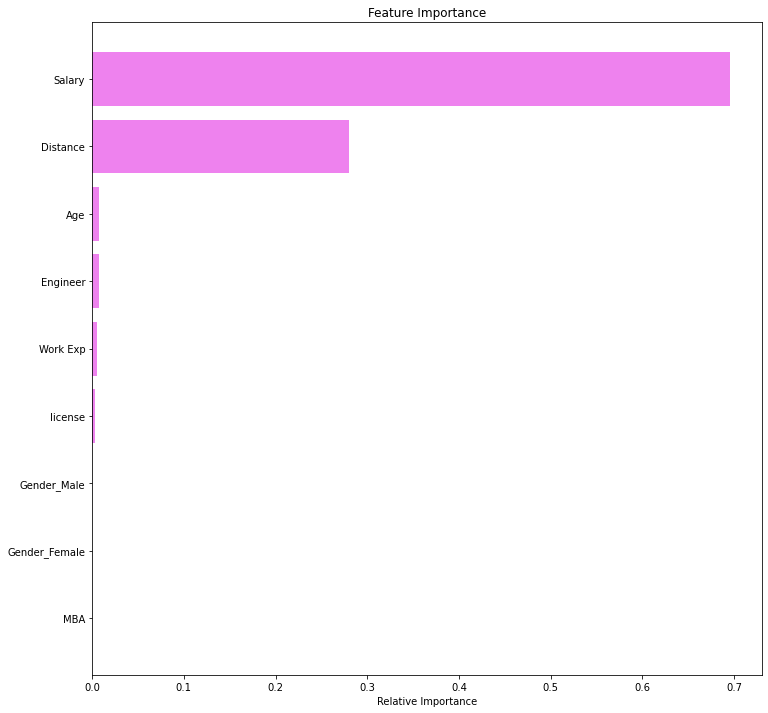

In [22]:
DisplayImportanceChart(gbm)

In [23]:
# Training first model
gbm1 = GradientBoostingClassifier(random_state=1, n_estimators=50, learning_rate = 0.01 )
gbm1.fit(X_train,y_train)

# Training second model
gbm2 = GradientBoostingClassifier(random_state=1, n_estimators=100, learning_rate = 0.01 )
gbm2.fit(X_train,y_train)

# Training third model
gbm3 = GradientBoostingClassifier(random_state=1, n_estimators=400, learning_rate = 0.01 )
gbm3.fit(X_train,y_train)

print('gbm1')
score = GetMetricsScore(gbm1)
pprint.pprint(score)

print('gbm2')
score = GetMetricsScore(gbm2)
pprint.pprint(score)

print('gbm3')
score = GetMetricsScore(gbm3)
pprint.pprint(score)

gbm1
{'Accuracy_Test': 0.9126984126984127,
 'Accuracy_Train': 0.9178082191780822,
 'F1_Score_Test': nan,
 'F1_Score_Train': nan,
 'Precision_Test': 0.0,
 'Precision_Train': 0.0,
 'Recall_Test': 0.0,
 'Recall_Train': 0.0}
gbm2
{'Accuracy_Test': 0.9761904761904762,
 'Accuracy_Train': 0.9965753424657534,
 'F1_Score_Test': 0.88,
 'F1_Score_Train': 0.9787234042553191,
 'Precision_Test': 0.7857142857142857,
 'Precision_Train': 1.0,
 'Recall_Test': 1.0,
 'Recall_Train': 0.9583333333333334}
gbm3
{'Accuracy_Test': 0.9761904761904762,
 'Accuracy_Train': 1.0,
 'F1_Score_Test': 0.88,
 'F1_Score_Train': 1.0,
 'Precision_Test': 0.7857142857142857,
 'Precision_Train': 1.0,
 'Recall_Test': 1.0,
 'Recall_Train': 1.0}


In [42]:
estimators = [('DT',DecisionTreeClassifier(random_state=1)),
 ('BAG',BaggingClassifier(random_state=1))]

# Training stacking classifier
clf = StackingClassifier(estimators = estimators, final_estimator = RandomForestClassifier(random_state=1))
clf.fit(X_train, y_train)

StackingClassifier(estimators=[('DT', DecisionTreeClassifier(random_state=1)),
                               ('BAG', BaggingClassifier(random_state=1))],
                   final_estimator=RandomForestClassifier(random_state=1))

In [43]:
y_pred = clf.predict(X_train)

In [44]:
score = GetMetricsScore(clf)
pprint.pprint(score)

{'Accuracy_Test': 0.9920634920634921,
 'Accuracy_Train': 0.9828767123287672,
 'F1_Score_Test': 0.9523809523809523,
 'F1_Score_Train': 0.8837209302325582,
 'Precision_Test': 1.0,
 'Precision_Train': 1.0,
 'Recall_Test': 0.9090909090909091,
 'Recall_Train': 0.7916666666666666}


In [29]:
estimators = [('GBM',GradientBoostingClassifier(random_state=1)),
 ('ABC',AdaBoostClassifier(random_state=1)),
 ]

# Training stacking classifier
clf = StackingClassifier(estimators = estimators, final_estimator = XGBClassifier(random_state=1, eval_metric='logloss'))
clf.fit(X_train, y_train)

score = GetMetricsScore(clf)
pprint.pprint(score)

{'Accuracy_Test': 0.9761904761904762,
 'Accuracy_Train': 1.0,
 'F1_Score_Test': 0.88,
 'F1_Score_Train': 1.0,
 'Precision_Test': 0.7857142857142857,
 'Precision_Train': 1.0,
 'Recall_Test': 1.0,
 'Recall_Train': 1.0}
